# Regularisation for Inverse Problems

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.util import random_noise
from skimage.restoration import wiener

# helper function
def plot_images(images, titles, fname=[]):
    n = len(images)
    fig, ax = plt.subplots(1,n)

    for k in range(n):
        ax[k].set_xticks([])
        ax[k].set_yticks([])
        ax[k].imshow(images[k], cmap=plt.cm.gray)
        ax[k].set_title(titles[k])

    fig.set_figwidth(10)
    fig.tight_layout()
    
    if fname:
        plt.savefig(fname,dpi=300)

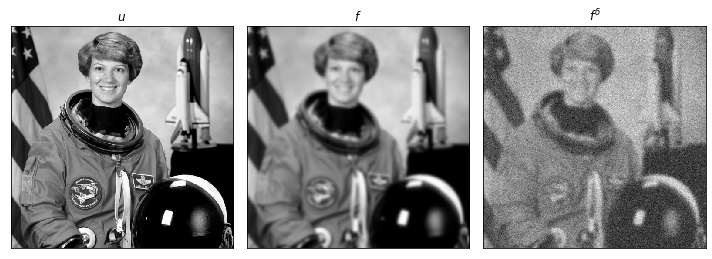

In [18]:
# read image
u = rgb2gray(data.astronaut())

# blur image
f = gaussian(u,3)

# add_noise
f_delta = random_noise(f, var = 0.01, clip=False)

# plot
plot_images([u, f, f_delta], [r'$u$', r'$f$', r'$f^\delta$'], 'example1.png')

# A typical Inverse Problem ...

![](example1.png)

# Overview

* Inverse Problems
* Regularisation
* Compressed sensing
* Data-driven regularisation

# Inverse problems in imaging

* $K$ - forward operator (convolution with PSF)
* $u$ - image (function or 2D array representing RGB values or intensity)
* $f$ - noiseless measurements ($f = Ku$)
* $f^\delta$ - noisey measurements ($f^\delta = f + \epsilon$ for additive noise)

> The goal is to retrieve $u$ given $K$ and $f^\delta$

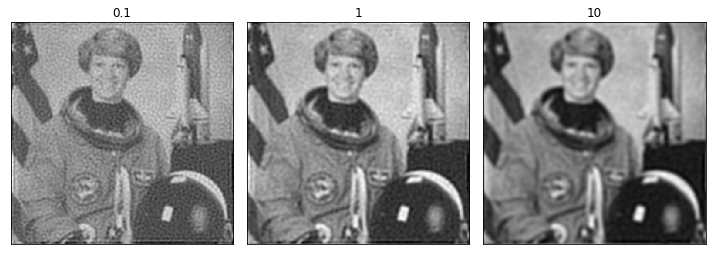

In [34]:
# read image
u = rgb2gray(data.astronaut())

# get psf
n,_ = u.shape
e = np.zeros((n,n))
e[n//2, n//2] = 1
psf = gaussian(e,3)

# blur image
f = gaussian(u,3)

# add_noise
f_delta = random_noise(f, var = 0.01, clip=False)

# apply inverse
alphas = [.1, 1, 10]
u_est = [0,0,0]
for k in range(3):
    u_est[k] = wiener(f_delta, psf, balance=alphas[k], clip=False) 

# 
plot_images(u_est, ['0.1', '1', '10'])